In [1]:
import tensorflow as tf
import numpy as np
import math
na = np.newaxis
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

# import helper functions from utils.py:
from utils import build_2d_grid, train_parameters, evaluation, tf_tril_indices, load_lookup_table, table_lookup_op_parallel, get_scp_samples, build_graph, build_eval_graph, get_test_log_likelihood


# Planning:

- test on simple example and compare real / optimized distributions (define real dist-> sample data -> calc approx -> compare)
- test on real dataset

### BUGS:
- urgent: logdet calculation gives Nans, current fix: replace the zeros by eye in the sparse add, does not solve it in any case however

-> try: does it work with decomp and I stabilizer?

- m and S values go to infinity if inducing_point_res >= 9


### TODOS:
- lower bound >0 ???
- Check T region definition (currently limits of inducing points)
- calculate and print lower bound for testset
- improve 2d sampling function
- optimize Lookup Table resolution (Max)

# 2d example

In [5]:
from scipy.stats import multivariate_normal

def double_blob(x):
    blob_1 = multivariate_normal.pdf(x, mean = [3, 3], cov=[[1, 0], [0, 1]])
    blob_2 = multivariate_normal.pdf(x, mean = [7, 7], cov=[[1, 0], [0, 1]])
    return (blob_1 + blob_2) * 10

def gram_matrix(xs):
    return np.array([[ard_kernel(x1,x2) for x2 in xs] for x1 in xs])

def ard_kernel(x1,x2):
    R = 2
    a = np.ones([R])*5
    g = 0.7
    return g * np.prod([np.exp(-1 * ((x1-x2) ** 2) / (2 * a[r])) for r in range(R)])

def gaussian_process_rate_function(xs):
    mean = [0 for x in xs]
    gram = gram_matrix(xs)
    result = np.random.multivariate_normal(mean, gram)**2

    return result

In [6]:
upper_bound = 2
Tlims = np.array([[0., 10.], [0., 10.]])
res = 20

#generate samples
samples,test_samples, _,xx, yy,vals = get_scp_samples(gaussian_process_rate_function, Tlims, upper_bound,res)
                                                    

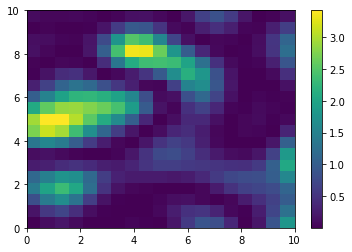

3.63724257885


In [7]:
#plot the rate_function over a grid
plot_vals = vals.reshape(res,res)
plt.pcolormesh(xx, yy, plot_vals.reshape(res,res))
plt.colorbar()
plt.show()

print(np.max(plot_vals))

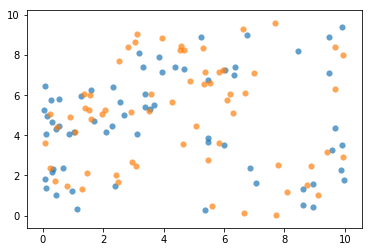

In [8]:
# sampled data:
plt.scatter(samples[:,0], samples[:,1], linewidth=0.1, alpha=.7)
plt.scatter(test_samples[:,0], test_samples[:,1], linewidth=0.1, alpha=.7)
plt.show()

# Variational Approximation

### 2D Parameter Learning

Begin training
ind point number:  6
alphas:  [ 1.  1.]
gamma:  0.5


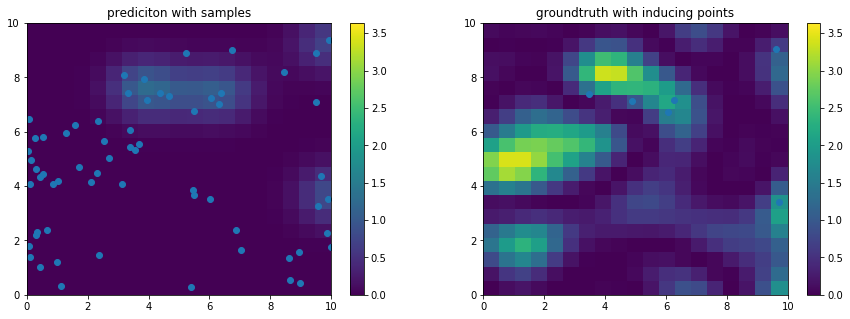

In [22]:
## ######## ##
# PARAMETERS #
## ######## ##

tf.logging.set_verbosity(tf.logging.DEBUG)

# general options
train_hyperparameters    = False
optimize_inducing_points = True
ind_point_nums           = [6]

# gradient descent optionss
max_iterations = 1000
learning_rate  = 0.0001

# hyperparameter initialization:
alphas_init = [1.,  1.]
gamma_init  = 0.5

# tensorboard options:
logdir = 'logs/2d_example'

# build_evaluation_grid
eval_grid = build_2d_grid(Tlims, res)

for n_ind, i in enumerate(ind_point_nums): 
        
    m_opt, S_opt, Kzz_inv_opt, alphas_opt, Z_opt,gamma_opt = train_parameters(samples, i, Tlims, 
                                                                              optimize_inducing_points=optimize_inducing_points, 
                                                                              train_hyperparameters=train_hyperparameters,
                                                                              learning_rate=learning_rate,
                                                                              max_iterations=max_iterations,
                                                                              log_dir=logdir,
                                                                              alphas_init=alphas_init,
                                                                              gamma_init=gamma_init
                                                                             )
    lam_vals,lam_var = evaluation(m_opt,S_opt,Kzz_inv_opt,alphas_opt,gamma_opt,Z_opt, eval_grid)

    #plots
    fig = plt.figure(figsize=(15, 5)) 
    max_value = np.max([np.max(vals), np.max(lam_vals)])
    norm = mpl.colors.Normalize(vmin=0, vmax=max_value)

    print("ind point number: ",i)
    print("alphas: ",alphas_opt)
    print("gamma: ",gamma_opt)
    
    xx, yy = np.meshgrid(np.linspace(Tlims[0,0], Tlims[0,1], res), np.linspace(Tlims[1,0], Tlims[1,1], res))
    
    ax0 = plt.subplot(1,2,1)
    im = ax0.pcolormesh(xx, yy, lam_vals.reshape(res,res),  norm=norm)
    fig.colorbar(im, ax=ax0)
    ax0.set_title('prediciton with samples')
    ax0.scatter(samples[:,0], samples[:,1])
    plt.xlim(Tlims[0,0], Tlims[0,1])
    plt.ylim(Tlims[1,0], Tlims[1,1])

    ax1 = plt.subplot(1,2, 2)
    im1 = ax1.pcolormesh(xx, yy, plot_vals, norm=norm)
    fig.colorbar(im1, ax=ax1)
    ax1.set_title('groundtruth with inducing points')
    ax1.scatter(Z_opt[:, 0], Z_opt[:,1])
    plt.xlim(Tlims[0,0], Tlims[0,1])
    plt.ylim(Tlims[1,0], Tlims[1,1])
    #plt.savefig('results/' + run_prefix + '_result.png', dpi=300)
    plt.show()

In [ ]:
def get_lower_test_bound(test_samples, m, S, Kzz_inv, a, g, Z):
    lower_bound, Z_ph, X_test_ph, m_ph, S_ph,K_zz_inv_ph,a_ph,g_ph  = get_test_log_likelihood()

    #run session
    with tf.Session() as sess:
        lower_bound_val, = sess.run([lower_bound], feed_dict={Z_ph:Z, X_test_ph:test_samples,K_zz_inv_ph: Kzz_inv,S_ph:S,m_ph:m,a_ph:a,g_ph:g})

    return lower_bound_val
